In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Example usage
# df=pd.read_excel("/content/drive/MyDrive/MSCI-623/default of credit card clients.xls", index_col=False)
df=pd.read_csv("/content/drive/MyDrive/MSCI-623/UCI_Credit_Card.csv", index_col=False)

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
# remove the first row containing column names
# df = df.drop(labels=0, axis=0)

In [ ]:
# rename outcome variable in an acceptable format to minimize any issues that might arise afterwards
df.rename(columns={"default.payment.next.month": "def_pay", "PAY_0": "PAY_1"}, inplace=True)

In [ ]:
df.shape

(30000, 25)

In [ ]:
# converting datatypes from object to numeric
#df = df.apply(pd.to_numeric)
df = df.astype(int)

In [ ]:
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_1        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
def_pay      int64
dtype: object

In [ ]:
# Had to rename 1st column name to 'ID' as lightGBMpredict was giving error stating unable to process non utf-8 char in column name
# df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)


In [ ]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'def_pay'],
      dtype='object')

In [ ]:
#Function to split the data in Train/Test and Validation

def def_split_data_train_test_validate(df, test_size=0.2, val_size=0.2, random_state=42):
    X=df.drop(['def_pay'], axis=1)
    y=df['def_pay']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
# Step 2: Fit models and predict
def fit_xgboost_light_GBM_predict(X_train, X_val, X_test, y_train, y_val, y_test):
    # XGBoost
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    # LightGBM
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_test)

    # Randomized Search for XGBoost
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }
    xgb_random_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, scoring='accuracy', cv=3)
    xgb_random_search.fit(X_train, y_train)
    xgb_random_pred = xgb_random_search.predict(X_test)

    return xgb_pred, lgb_pred,xgb_random_pred

 # You can choose any prediction array here

In [ ]:
# Step 3: Print evaluation metrics
def print_evaluation(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)

    print(model_name + "=>")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Kappa Score:", kappa)
    print("Confusion Matrix:")
    print(confusion)


In [ ]:
# Step 4: Plot ROC curve
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Step 5: Print classification report
def print_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred)
    print("Classification Report for "+model_name+":")
    print(report)


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = def_split_data_train_test_validate(df)
xgb_pred, lgb_pred,xgb_random_pred = fit_xgboost_light_GBM_predict(X_train, X_val, X_test, y_train, y_val, y_test)


In [ ]:
# Print evaluation metrics
print("XGBoost Evaluation:")
print_evaluation(y_test, xgb_pred, 'XGBoost')


XGBoost Evaluation:
XGBoost=>
Accuracy: 0.8173333333333334
Precision: 0.6460296096904441
Recall: 0.3655750190403656
F1 Score: 0.46692607003891046
Kappa Score: 0.3667718131029316
Confusion Matrix:
[[4424  263]
 [ 833  480]]


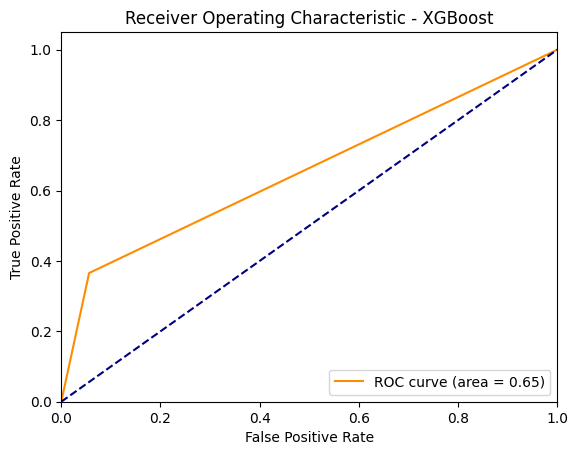

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test, xgb_pred, 'XGBoost')  # You can choose any prediction array here


In [ ]:
# Print classification report
print_classification_report(y_test, xgb_pred, 'XGBoost')

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.65      0.37      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [ ]:
print("LightGBM Evaluation:")
print_evaluation(y_test, lgb_pred, 'LightGBM')


LightGBM Evaluation:
LightGBM=>
Accuracy: 0.8218333333333333
Precision: 0.6689750692520776
Recall: 0.36785986290936784
F1 Score: 0.4746928746928747
Kappa Score: 0.37812850614716187
Confusion Matrix:
[[4448  239]
 [ 830  483]]


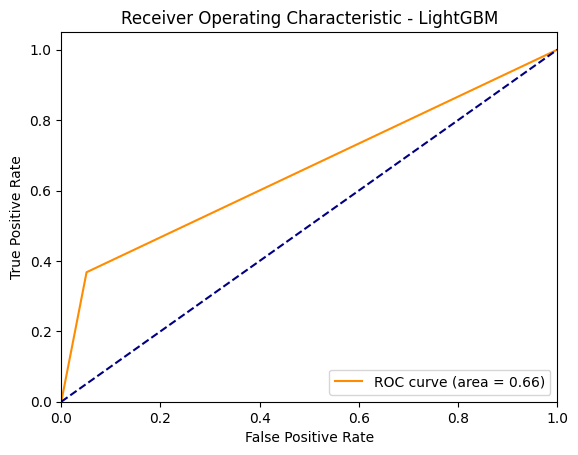

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test, lgb_pred, 'LightGBM')  # You can choose any prediction array here


In [ ]:
# Print classification report
print_classification_report(y_test, lgb_pred, 'LightGBM')

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.37      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [ ]:
print("Logistic Regression:")
print_evaluation(y_test, xgb_random_pred, 'Logistic Regression')


Logistic Regression:
Logistic Regression=>
Accuracy: 0.8216666666666667
Precision: 0.6768558951965066
Recall: 0.3541507996953541
F1 Score: 0.465
Kappa Score: 0.3703374814558503
Confusion Matrix:
[[4465  222]
 [ 848  465]]


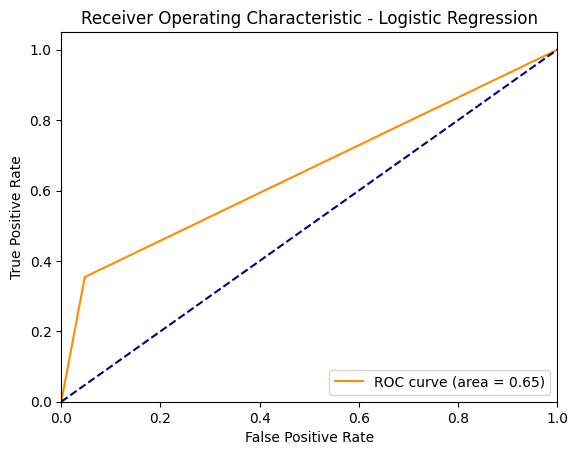

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test, xgb_random_pred, 'Logistic Regression')  # You can choose any prediction array here


In [ ]:
# Print classification report
print_classification_report(y_test, xgb_random_pred, 'Logistic Regression')

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.68      0.35      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

